# 信息熵计算函数

In [1]:
# 导入 numpy 库，对数计算
import numpy as np
from math import log
def entropy(ele):
    """
    输入:
        ele->包含类别取值的列表
    输出:
        entropy->信息熵值
    """
    # 计算列表中取值的概率分布
    probs = [ele.count(i)/len(ele) for i in set(ele)]
    # 计算信息熵
    entropy = -sum(prob * log(prob, 2) for prob in probs)
    p = ele.value_counts(normalize=True)
    return - np.dot(p, np.log2(p))
    return entropy

# 数据集划分函数

In [2]:
def df_split(df, col):
    """
    输入:
        df->待划分的训练数据
        col->划分数据的依据特征
    输出:
        res_dict->根据特征取值划分后的不同数据集字典
    """
    # 获取依据特征的不同取值
    unique_col_val = df[col].unique()
    # 创建划分结果的数据框字典
    res_dict = {elem:pd.DataFrame for elem in unique_col_val}
    # 根据特征取值进行划分
    for key in res_dict.keys():
        res_dict[key] = df[:][df[col] == key]
    return res_dict

# 选择最优特征

In [1]:
# 根据训练集和标签选择信息增益最大的特征作为最优特征
def choose_best_feature(df, label):
    """
    输入:
        df->待划分的训练数据
        label->训练标签
    输出:
        mas_value->最大信息增益值
        best_feature->最优特征
        max_splited->根据最优特征划分后的数据字典
    """
    # 计算训练标签的信息熵
    entropy_D = entropy(df[label].tolist())
    # 特征集
    cols = [col for col in df.columns if col not in [label]]
    # 初始化最大信息增益值、最优特征和划分后的数据集
    max_value, best_feature = -999, None
    max_splited = None
    # 遍历特征并根据特征划分后的数据集
    for col in cols:
        # 根据当前特征取值划分后的数据集
        splited_set = df_split(df, col)
        # 初始化经验条件熵
        entropy_DA = 0
        # 对划分后的数据集遍历计算
        for subset_col, subset in splited_set.items():
            # 计算划分后的数据子集的标签信息熵
            entropy_Di = entropy(subset[label].tolist())
            # 计算当前特征的经验条件熵
            entropy_DA += len(subset)/len(df) * entropy_Di
        # 计算当前特征的信息增益
        info_gain = entropy_D - entropy_DA
        
        # 信息增益率
        entropy_A = entropy(df[label].tolist())
        if(entropy_A != 0):
            info_gain_rate = info_gain/entropy_A
        else:
            info_gain_rate = 0;
        #print(col, info_gain_rate)
        # 获取最大信息增益比，并保存对应的特征和划分结果
        if info_gain_rate > max_value:
            max_value, best_feature = info_gain_rate, col
            max_splited = splited_set
    #print()
    return max_value, best_feature, max_splited

# 构建 C4.5 决策树

In [4]:
class ID3tree:
    # 定义决策树结点类
    class TreeNode:
        # 定义树节点
        def __init__(self, name):
            self.name = name
            self.connections = {}
        # 定义树连接
        def connect(self, label, node):
            self.connections[label] = node
    # 定义全局变量，包括数据集、特征集、标签和根节点
    def __init__(self, df, label):
        self.columns = df.columns
        self.df = df
        self.label = label
        self.root = self.TreeNode("Root")
    
    # 构建树的调用
    def construct_tree(self):
        self.construct(self.root, "", self.df, self.columns)
        
    # 决策树构建方法
    def construct(self, parent_node, parent_label, sub_df, columns):
        # 选择最优特征
        max_value, best_feature, max_splited = choose_best_feature(sub_df[columns], self.label)
        # 如果选不到最优特征的，则构建单结点树
        if not best_feature:
            node = self.TreeNode(sub_df[self.label].iloc[0])
            parent_node.connect(parent_label, node)
            return 
        # 根据最优特征以及子结点构建树
        node = self.TreeNode(best_feature)
        parent_node.connect(parent_label, node)
        # 以 A-Ag 为新的特征集
        new_columns = [col for col in columns if col != best_feature]
        # 递归地构建决策树
        for splited_value, splited_data in max_splited.items():
            self.construct(node, splited_value, splited_data, new_columns)
            
    # 打印决策树
    def print_tree(self, node, tabs):
        print(tabs + str(node.name))
        for connection, child_node in node.connections.items():
            print(str(tabs) + "\t" + "(" + str(connection) + ")")
            self.print_tree(child_node, tabs + "\t")
            
    # 预测
    def find(self, node, test):
        if node.name == 1:
            return 1
        elif node.name == 0:
            return 0
        for connection, child_node in node.connections.items():
            if connection == "" or connection == test[node.name]:
                return self.find(child_node, test)
    def predict(self, X_test):
        pred = []
        for i in range(0,len(X_test)):
            test = X_test.loc[X_test.index[i]]
            pred.append(self.find(self.root, test))
        return pred
    
    # accuracy
    def accuracy(self, y_test, pred):
        tp, tn = 0, 0
        for i in range(0, len(y_test)):
            if y_test[i] == 1 and pred[i] == 1:
                tp += 1
            if y_test[i] == 0 and pred[i] == 0:
                tn += 1
        return (tp + tn)/len(y_test)
        np.mean(y_test == pred)
    
    # precision
    def precision(self, y_test, pred):
        tp, fp = 0, 0
        for i in range(0, len(y_test)):
            if y_test[i] == 1 and pred[i] == 1:
                tp += 1
            if y_test[i] == 0 and pred[i] == 1:
                tn += 1
        return tp/(tp + fp)
    
    # recall
    def recall(self, y_test, pred):
        tp, fn = 0, 0
        for i in range(0, len(y_test)):
            if y_test[i] == 1 and pred[i] == 1:
                tp += 1
            if y_test[i] == 1 and pred[i] == 0:
                tn += 1
        return tp/(tp + fn)

# 基于西瓜数据集的 C4.5 决策树

Root
	()
	纹理
		(1)
		根蒂
			(2)
			色泽
				(2)
				敲声
					(1)
					脐部
						(0)
						触感
							(0)
							1
					(0)
					脐部
						(0)
						触感
							(0)
							1
				(0)
				敲声
					(0)
					脐部
						(0)
						触感
							(0)
							1
					(1)
					脐部
						(0)
						触感
							(0)
							1
				(1)
				敲声
					(1)
					脐部
						(0)
						触感
							(0)
							1
			(1)
			色泽
				(2)
				敲声
					(1)
					脐部
						(2)
						触感
							(1)
							1
				(0)
				触感
					(0)
					敲声
						(1)
						脐部
							(2)
							1
					(1)
					敲声
						(1)
						脐部
							(2)
							0
			(0)
			色泽
				(2)
				敲声
					(2)
					脐部
						(1)
						触感
							(1)
							0
		(2)
		触感
			(1)
			色泽
				(0)
				根蒂
					(1)
					敲声
						(1)
						脐部
							(2)
							1
			(0)
			色泽
				(0)
				根蒂
					(1)
					敲声
						(0)
						脐部
							(2)
							0
				(2)
				根蒂
					(1)
					敲声
						(1)
						脐部
							(0)
							0
					(2)
					敲声
						(0)
						脐部
							(2)
							0
				(1)
				根蒂
					(1)
					敲声
					

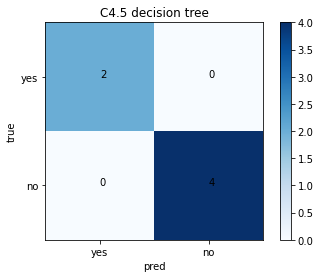

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# 载入数据
df = pd.read_csv("./watermelon.csv")
df = df.drop(columns=["编号"])

# 编码
encoder=preprocessing.LabelEncoder()
for i in range(0,df.shape[1]):
    df[df.columns[i]]=encoder.fit_transform(df[df.columns[i]])

X = df[["色泽", "根蒂", "敲声", "纹理", "脐部", "触感"]]
y = df["好瓜"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
# 创建 ID3 实例模型
id3_tree = ID3tree(df, "好瓜")

# 构建 ID3 决策树
id3_tree.construct_tree()

# 打印决策树
id3_tree.print_tree(id3_tree.root, "")

# 预测
print()
pred = id3_tree.predict(X_test)
y_test = list(y_test)
print(y_test)
print(pred)

# 评价指标
print("accuracy: ", id3_tree.accuracy(y_test, pred))
print("precision: ", id3_tree.precision(y_test, pred))
print("recall: ", id3_tree.recall(y_test, pred))

# confusion_matrix
print("混淆矩阵:")
import matplotlib.pyplot as plt
from sklearn import metrics
conm = metrics.confusion_matrix(pred, y_test)
plt.imshow(conm, cmap = plt.cm.Blues)
plt.xticks(range(len(conm)), ["yes", "no"])
plt.yticks(range(len(conm)), ["yes", "no"])
plt.colorbar()
plt.xlabel("pred")
plt.ylabel("true")
plt.title("C4.5 decision tree")
for i in range(len(conm)):
    for j in range(len(conm)):
        plt.text(i, j, conm[i][j])
plt.show()